In [6]:
"""
# Normalizing Flows Implementation Guide

## Introduction
Normalizing flows are a class of generative models that learn complex probability distributions 
by transforming a simple base distribution through a sequence of invertible mappings.

## Key Concepts

### 1. Change of Variables Formula
The fundamental principle behind normalizing flows is the change of variables formula:
p_x(x) = p_z(z) * |det(dz/dx)|
where:
- p_x(x) is the target distribution
- p_z(z) is the base distribution (usually standard normal)
- |det(dz/dx)| is the absolute determinant of the Jacobian

### 2. Flow Types
Different flow architectures provide different ways to transform the data while maintaining
invertibility and tractable Jacobian determinants:
- Planar: Uses planar transformations (f(z) = z + u*h(w^T*z + b))
- Radial: Uses radial transformations around a learned reference point
- RealNVP: Uses affine coupling layers with masked transformations
- MAF: Uses autoregressive transformations for increased flexibility
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import Normal


In [7]:
def create_toy_dataset(n_samples=1000, dataset_type='two_gaussians'):
    """
    Creates various 2D toy datasets
    """
    if dataset_type == 'two_gaussians':
        z = np.random.randn(n_samples, 2) * 0.5
        z[:n_samples//2, 0] += 2
        z[n_samples//2:, 0] -= 2
    elif dataset_type == 'circles':
        r = np.random.normal(1, 0.1, n_samples)
        theta = np.random.uniform(0, 2*np.pi, n_samples)
        z = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
    elif dataset_type == 'moons':
        t = np.random.uniform(0, np.pi, n_samples)
        x = np.cos(t)
        y = np.sin(t)
        z1 = np.stack([x, y], axis=1)
        z2 = np.stack([x+1, y-1], axis=1)
        z = np.vstack([z1[:n_samples//2], z2[n_samples//2:]])
        z += np.random.normal(0, 0.1, z.shape)
    
    return torch.FloatTensor(z)

In [8]:
class PlanarFlow(nn.Module):
    """
    Planar flow with fixed log determinant shape
    """
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        return z + self.u * activation
    
    def log_det_jacobian(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        psi = (1 - activation**2) * self.w
        det = 1 + torch.matmul(psi, self.u.T)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RadialFlow(nn.Module):
    """
    Radial flow: f(z) = z + β h(α,r)(z-z_0)
    where r is the distance from z_0 and h(α,r) = 1/(α + r)
    """
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.log_alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        return z + self.beta * h * (z - self.z0)
    
    def log_det_jacobian(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        h_prime = -1 / (alpha + r)**2
        det = (1 + self.beta * h + self.beta * h_prime * r)**(z.shape[1] - 1)
        det *= (1 + self.beta * h)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RealNVPCoupling(nn.Module):
    """
    Real NVP coupling layer
    Reference: https://arxiv.org/abs/1605.08803
    """
    def __init__(self, dim, hidden_dim=64, mask_type='alternate'):
        super().__init__()
        self.dim = dim
        
        # Create mask
        self.mask = torch.ones(dim)
        if mask_type == 'alternate':
            self.mask[::2] = 0
        elif mask_type == 'half':
            self.mask[:dim//2] = 0
            
        # Scale and translation networks
        self.s_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )
        
        self.t_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, z):
        masked_z = z * self.mask
        s = self.s_network(masked_z) * (1 - self.mask)
        t = self.t_network(masked_z) * (1 - self.mask)
        
        # Scale and shift
        exp_s = torch.exp(s)
        transformed = z * self.mask + (1 - self.mask) * (z * exp_s + t)
        log_det = torch.sum(s * (1 - self.mask), dim=1)
        
        return transformed, log_det

class MAF(nn.Module):
    """
    Masked Autoregressive Flow
    Reference: https://arxiv.org/abs/1705.07057
    """
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        
        # Create MADE-like network
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)  # Output both μ and log_σ
        )
        
        # Create autoregressive mask
        self.register_buffer('mask', self._create_mask())
        
    def _create_mask(self):
        # Create a lower triangular mask
        mask = torch.tril(torch.ones(self.dim, self.dim), -1)
        return mask
    
    def forward(self, z):
        batch_size = z.size(0)
        
        # Get parameters from network
        net_out = self.net(z)
        mu, log_sigma = net_out.chunk(2, dim=1)
        
        # Reshape mask for broadcasting
        mask = self.mask.unsqueeze(0)  # [1, dim, dim]
        
        # Apply mask to ensure autoregressive property
        # Compute masked mu: [batch_size, dim]
        masked_mu = torch.bmm(mask.expand(batch_size, -1, -1), 
                            z.unsqueeze(2)).squeeze(2)
        
        # Transform
        sigma = torch.exp(log_sigma)
        transformed = (z - masked_mu) / sigma
        log_det = -torch.sum(log_sigma, dim=1)
        
        return transformed, log_det


In [9]:
class NormalizingFlow(nn.Module):
    """
    A sequence of normalizing flows with proper log determinant handling
    """
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        
    def forward(self, z):
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        
        for flow in self.flows:
            if isinstance(flow, (RealNVPCoupling, MAF)):
                z, log_det = flow(z)
            else:
                log_det = flow.log_det_jacobian(z)
                z = flow(z)
                
            # Ensure log_det has correct shape [batch_size]
            if log_det.dim() > 1:
                log_det = log_det.sum(1)
            elif log_det.dim() == 0:
                log_det = log_det.expand(z.size(0))
                
            log_det_sum += log_det
            
        return z, log_det_sum



In [10]:
def visualize_flow(flow, data, n_samples=1000):
    """
    Create comprehensive visualizations of the flow with improved numerical stability
    """
    with torch.no_grad():
        # Generate samples
        z = torch.randn(n_samples, 2)
        samples, _ = flow(z)
        
        # Clip extreme values
        samples = torch.clamp(samples, -10, 10)
        
        samples = samples.numpy()
        z = z.numpy()
        data = data.numpy()
    
    # Function to safely compute histogram
    def safe_histogram2d(x, y, bins=50):
        # Remove any infinite or NaN values
        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]
        
        # Compute reasonable bounds
        x_min, x_max = np.percentile(x, [1, 99])
        y_min, y_max = np.percentile(y, [1, 99])
        
        range_tuple = [[x_min, x_max], [y_min, y_max]]
        return np.histogram2d(x, y, bins=bins, range=range_tuple, density=True)
    
    fig = plt.figure(figsize=(15, 10))
    
    # Original distribution
    plt.subplot(231)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Original Distribution')
    
    # Base distribution
    plt.subplot(232)
    plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Base Distribution (Normal)')
    
    # Generated distribution
    plt.subplot(233)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Generated Distribution')
    
    # Histograms with safe ranges
    plt.subplot(234)
    h, xedges, yedges = safe_histogram2d(data[:, 0], data[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Original Distribution (2D Histogram)')
    
    plt.subplot(235)
    h, xedges, yedges = safe_histogram2d(z[:, 0], z[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Base Distribution (2D Histogram)')
    
    plt.subplot(236)
    h, xedges, yedges = safe_histogram2d(samples[:, 0], samples[:, 1])
    plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
               aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Generated Distribution (2D Histogram)')
    
    plt.tight_layout()
    return fig

def train_flow(flow, data, n_epochs=1000, lr=1e-4):
    """
    Train the normalizing flow with improved numerical stability
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        try:
            # Forward pass through flow
            z, log_det = flow(data)
            
            # Clip extreme values
            z = torch.clamp(z, -10, 10)
            log_det = torch.clamp(log_det, -100, 100)
            
            # Compute loss (negative log likelihood)
            prior_ll = -0.5 * (z**2).sum(1) - 0.5 * np.log(2*np.pi) * z.shape[1]
            loss = -(prior_ll + log_det).mean()
            
            # Check for invalid values
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss value at epoch {epoch+1}")
                continue
            
            # Clip loss for stability
            loss = torch.clamp(loss, -1e6, 1e6)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Add parameter constraints after optimization step
            with torch.no_grad():
                for param in flow.parameters():
                    param.data.clamp_(-10, 10)
            
            losses.append(loss.item())
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')
                
        except RuntimeError as e:
            print(f"Error at epoch {epoch+1}: {str(e)}")
            continue
    
    return flow, losses


Training on two_gaussians dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 4.4440
Epoch 200/3000, Loss: 4.4042
Epoch 300/3000, Loss: 4.3665
Epoch 400/3000, Loss: 4.3302
Epoch 500/3000, Loss: 4.2959
Epoch 600/3000, Loss: 4.2644
Epoch 700/3000, Loss: 4.2349
Epoch 800/3000, Loss: 4.2063
Epoch 900/3000, Loss: 4.1781
Epoch 1000/3000, Loss: 4.1504
Epoch 1100/3000, Loss: 4.1231
Epoch 1200/3000, Loss: 4.0961
Epoch 1300/3000, Loss: 4.0695
Epoch 1400/3000, Loss: 4.0433
Epoch 1500/3000, Loss: 4.0173
Epoch 1600/3000, Loss: 3.9917
Epoch 1700/3000, Loss: 3.9664
Epoch 1800/3000, Loss: 3.9415
Epoch 1900/3000, Loss: 3.9169
Epoch 2000/3000, Loss: 3.8926
Epoch 2100/3000, Loss: 3.8687
Epoch 2200/3000, Loss: 3.8451
Epoch 2300/3000, Loss: 3.8219
Epoch 2400/3000, Loss: 3.7990
Epoch 2500/3000, Loss: 3.7764
Epoch 2600/3000, Loss: 3.7542
Epoch 2700/3000, Loss: 3.7323
Epoch 2800/3000, Loss: 3.7108
Epoch 2900/3000, Loss: 3.6896
Epoch 3000/3000, Loss: 3.6688


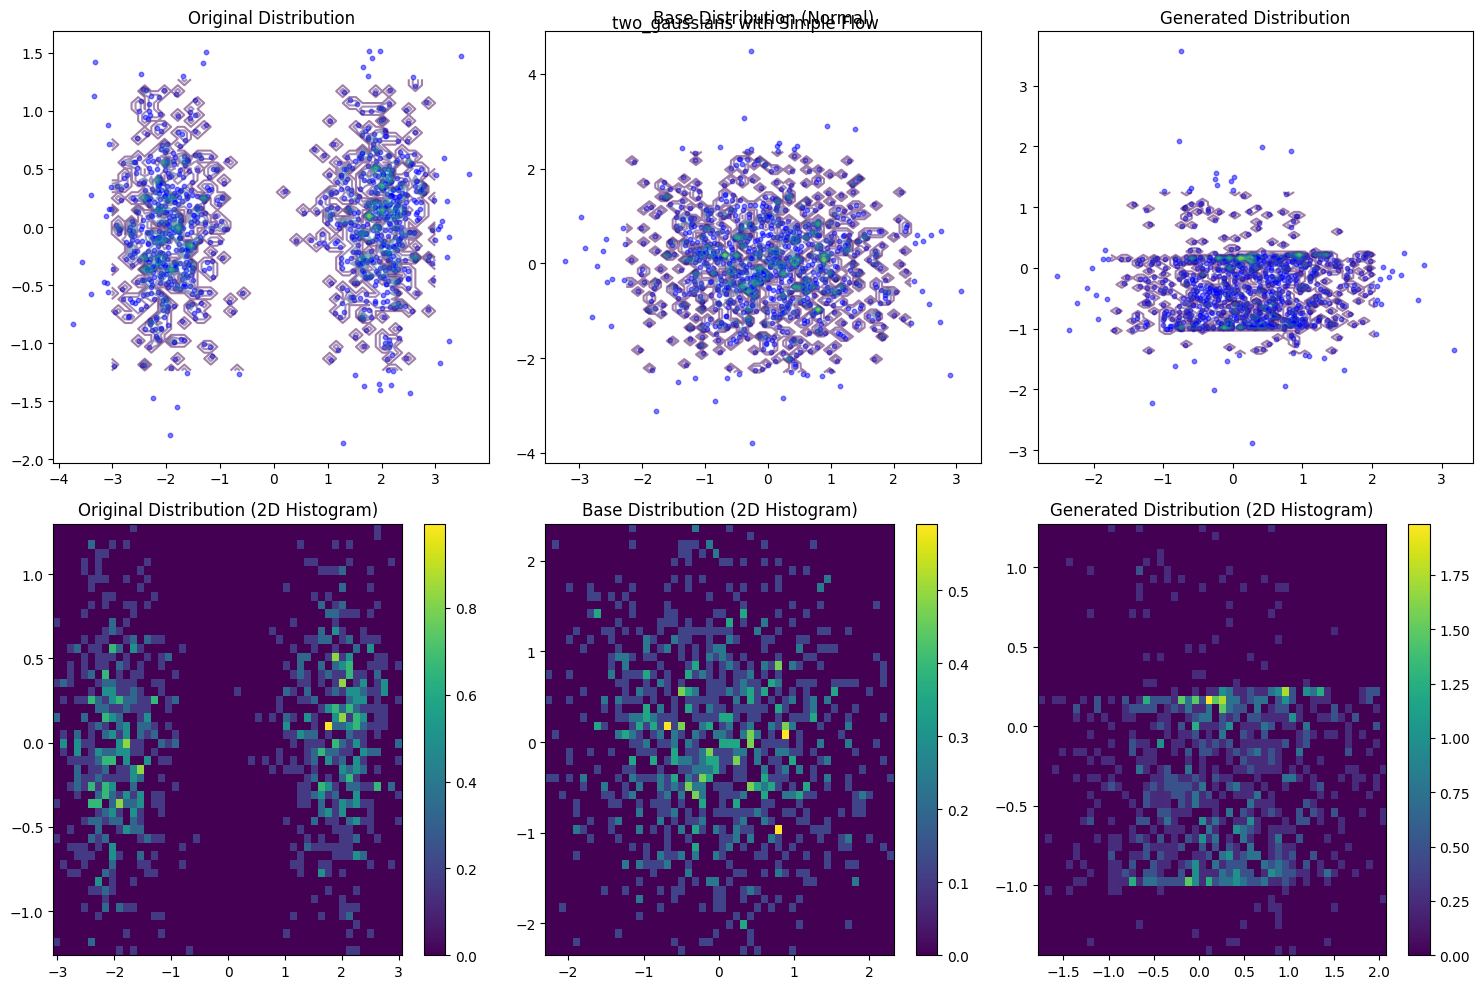

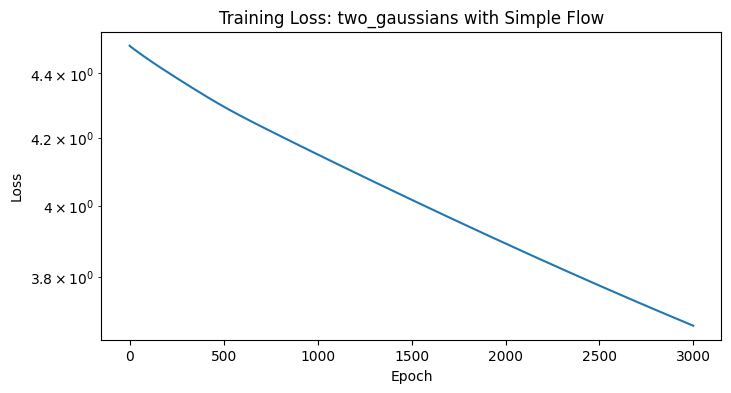


Training RealNVP architecture...
Epoch 100/3000, Loss: 3.1853
Epoch 200/3000, Loss: 3.1824
Epoch 300/3000, Loss: 3.1818
Epoch 400/3000, Loss: 3.1814
Epoch 500/3000, Loss: 3.1810
Epoch 600/3000, Loss: 3.1806
Epoch 700/3000, Loss: 3.1801
Epoch 800/3000, Loss: 3.1797
Epoch 900/3000, Loss: 3.1792
Epoch 1000/3000, Loss: 3.1788
Epoch 1100/3000, Loss: 3.1783
Epoch 1200/3000, Loss: 3.1778
Epoch 1300/3000, Loss: 3.1773
Epoch 1400/3000, Loss: 3.1768
Epoch 1500/3000, Loss: 3.1762
Epoch 1600/3000, Loss: 3.1757
Epoch 1700/3000, Loss: 3.1752
Epoch 1800/3000, Loss: 3.1746
Epoch 1900/3000, Loss: 3.1740
Epoch 2000/3000, Loss: 3.1734
Epoch 2100/3000, Loss: 3.1728
Epoch 2200/3000, Loss: 3.1722
Epoch 2300/3000, Loss: 3.1716
Epoch 2400/3000, Loss: 3.1710
Epoch 2500/3000, Loss: 3.1704
Epoch 2600/3000, Loss: 3.1698
Epoch 2700/3000, Loss: 3.1692
Epoch 2800/3000, Loss: 3.1686
Epoch 2900/3000, Loss: 3.1681
Epoch 3000/3000, Loss: 3.1675


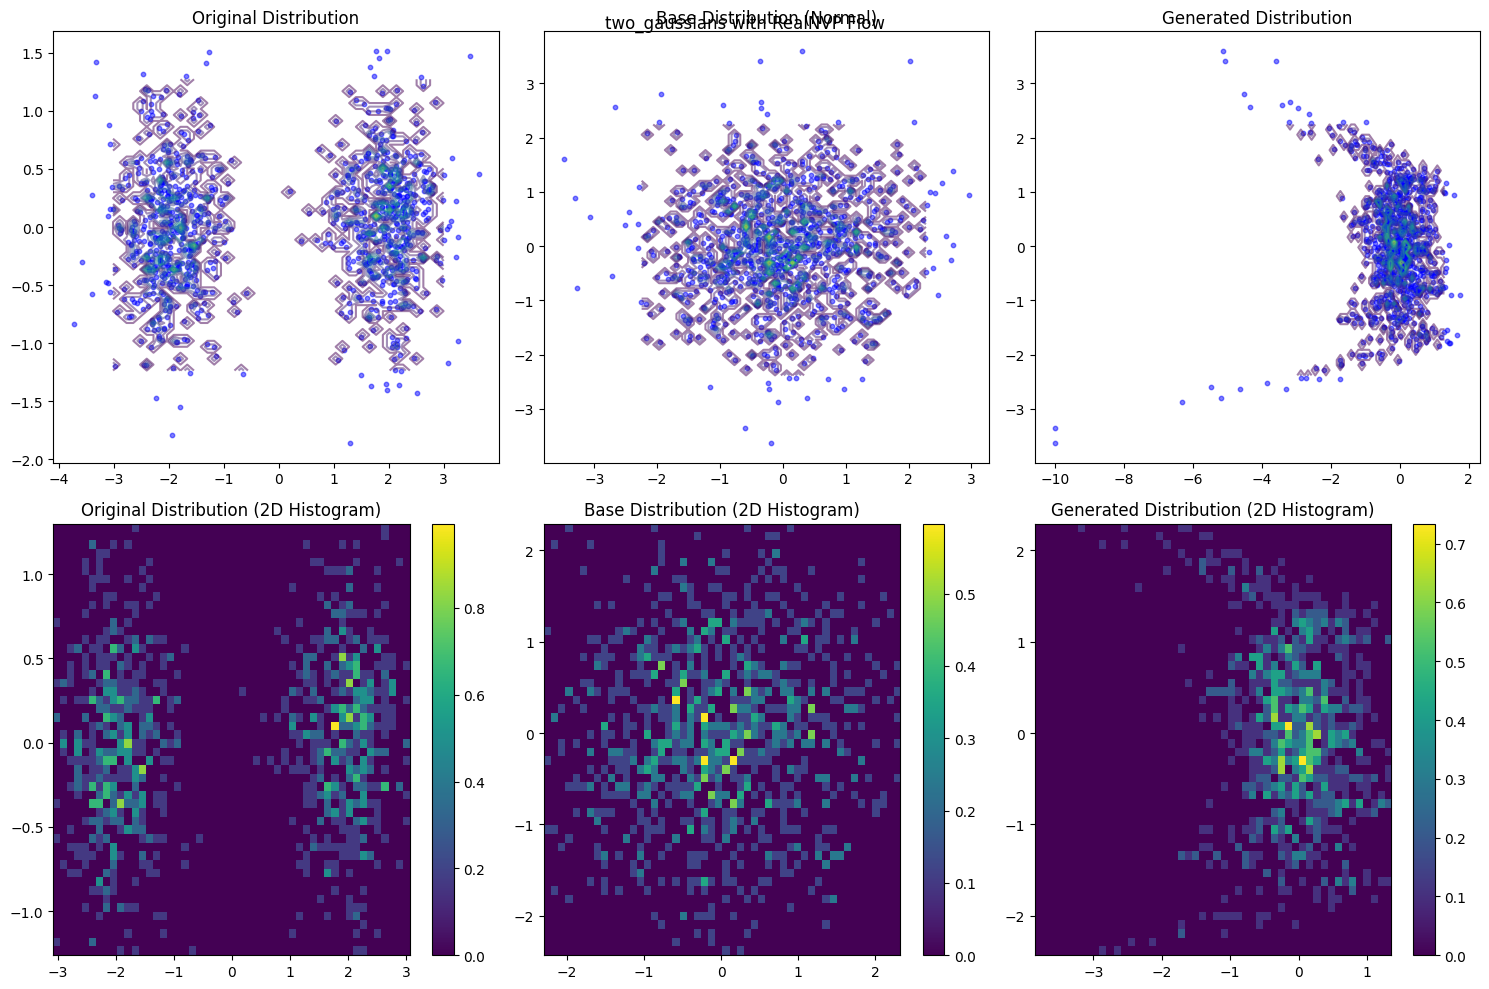

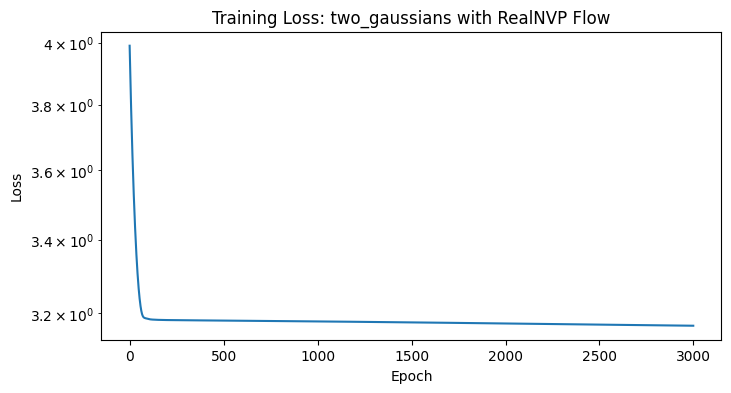


Training MAF architecture...
Epoch 100/3000, Loss: 5.0543
Epoch 200/3000, Loss: 4.3423
Epoch 300/3000, Loss: 4.1815
Epoch 400/3000, Loss: 4.1309
Epoch 500/3000, Loss: 4.1042
Epoch 600/3000, Loss: 4.0900
Epoch 700/3000, Loss: 4.0828
Epoch 800/3000, Loss: 4.0794
Epoch 900/3000, Loss: 4.0766
Epoch 1000/3000, Loss: 4.0743
Epoch 1100/3000, Loss: 4.0715
Epoch 1200/3000, Loss: 4.0695
Epoch 1300/3000, Loss: 4.0678
Epoch 1400/3000, Loss: 4.0662
Epoch 1500/3000, Loss: 4.0647
Epoch 1600/3000, Loss: 4.0635
Epoch 1700/3000, Loss: 4.0624
Epoch 1800/3000, Loss: 4.0615
Epoch 1900/3000, Loss: 4.0606
Epoch 2000/3000, Loss: 4.0598
Epoch 2100/3000, Loss: 4.0591
Epoch 2200/3000, Loss: 4.0584
Epoch 2300/3000, Loss: 4.0579
Epoch 2400/3000, Loss: 4.0574
Epoch 2500/3000, Loss: 4.0569
Epoch 2600/3000, Loss: 4.0566
Epoch 2700/3000, Loss: 4.0562
Epoch 2800/3000, Loss: 4.0559
Epoch 2900/3000, Loss: 4.0556
Epoch 3000/3000, Loss: 4.0552


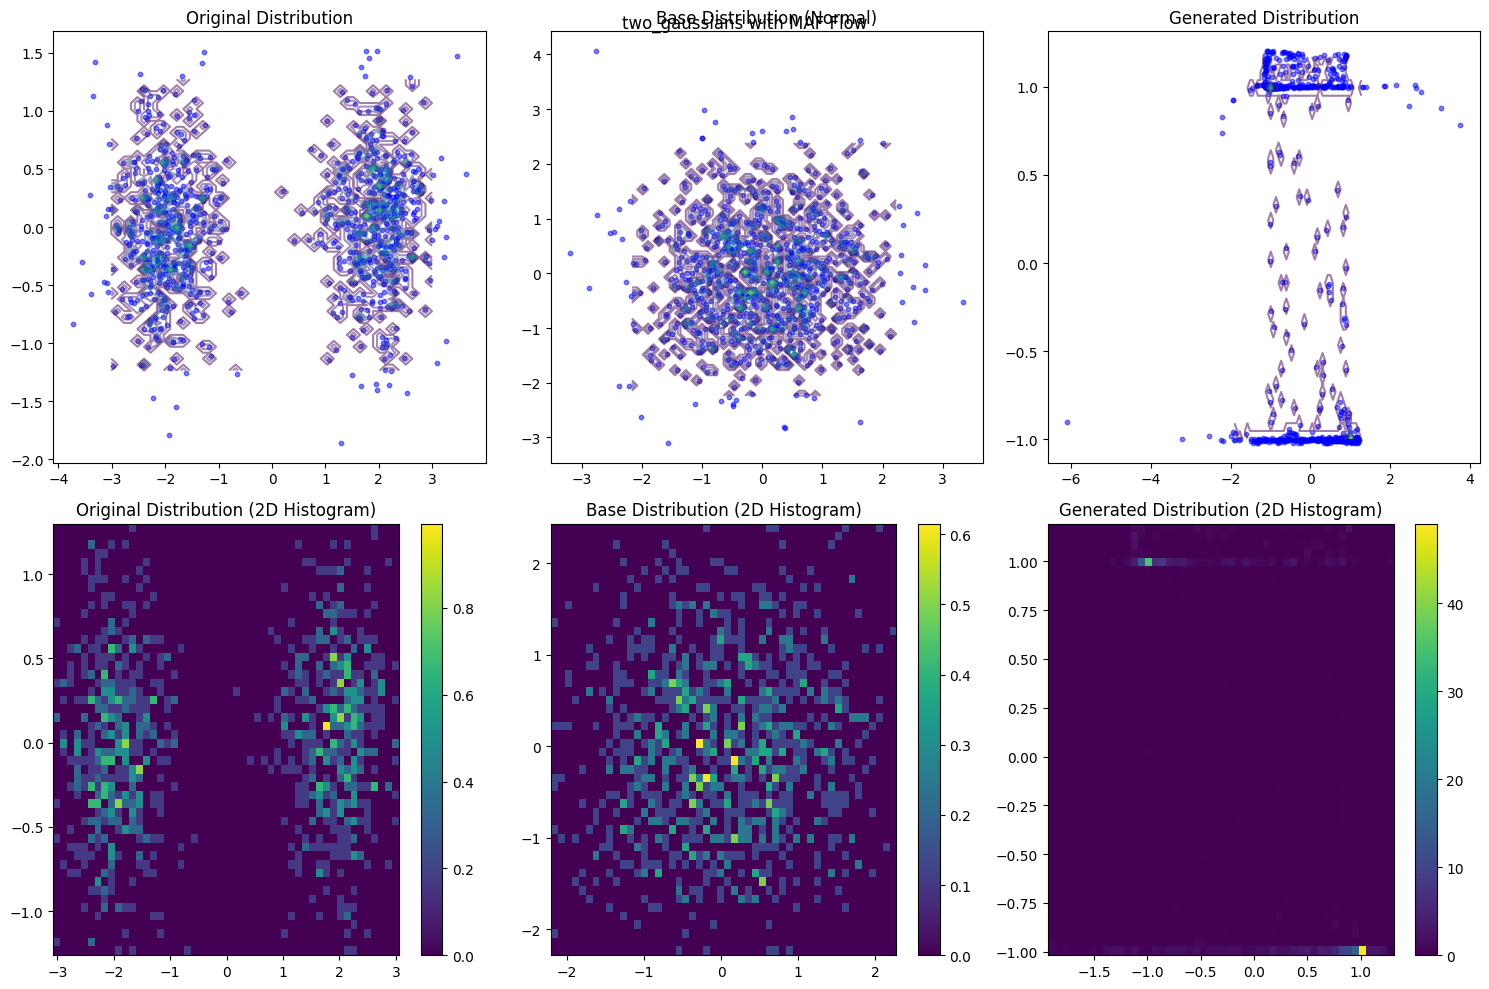

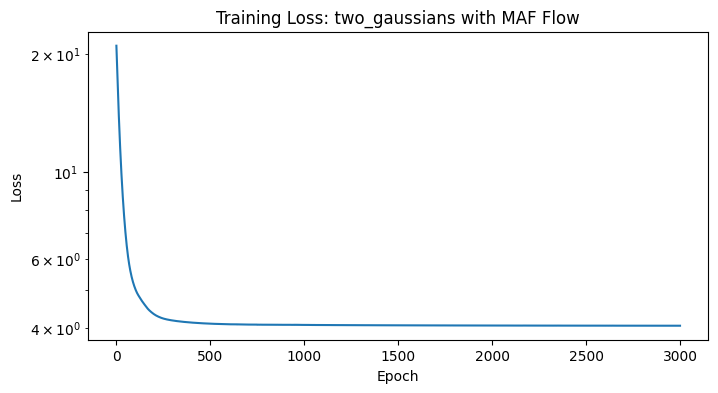


Training Mixed architecture...
Epoch 100/3000, Loss: 3.4543
Epoch 200/3000, Loss: 2.9528
Epoch 300/3000, Loss: 2.6370
Epoch 400/3000, Loss: 2.3436
Epoch 500/3000, Loss: 2.1200
Epoch 600/3000, Loss: 1.9729
Epoch 700/3000, Loss: 1.8794
Epoch 800/3000, Loss: 1.8131
Epoch 900/3000, Loss: 1.7575
Epoch 1000/3000, Loss: 1.7104
Epoch 1100/3000, Loss: 1.6682
Epoch 1200/3000, Loss: 1.6310
Epoch 1300/3000, Loss: 1.5979
Epoch 1400/3000, Loss: 1.5662
Epoch 1500/3000, Loss: 1.5363
Epoch 1600/3000, Loss: 1.5075
Epoch 1700/3000, Loss: 1.4790
Epoch 1800/3000, Loss: 1.4507
Epoch 1900/3000, Loss: 1.4235
Epoch 2000/3000, Loss: 1.3979
Epoch 2100/3000, Loss: 1.3741
Epoch 2200/3000, Loss: 1.3526
Epoch 2300/3000, Loss: 1.3325
Epoch 2400/3000, Loss: 1.3133
Epoch 2500/3000, Loss: 1.2952
Epoch 2600/3000, Loss: 1.2777
Epoch 2700/3000, Loss: 1.2616
Epoch 2800/3000, Loss: 1.2466
Epoch 2900/3000, Loss: 1.2329
Epoch 3000/3000, Loss: 1.2201


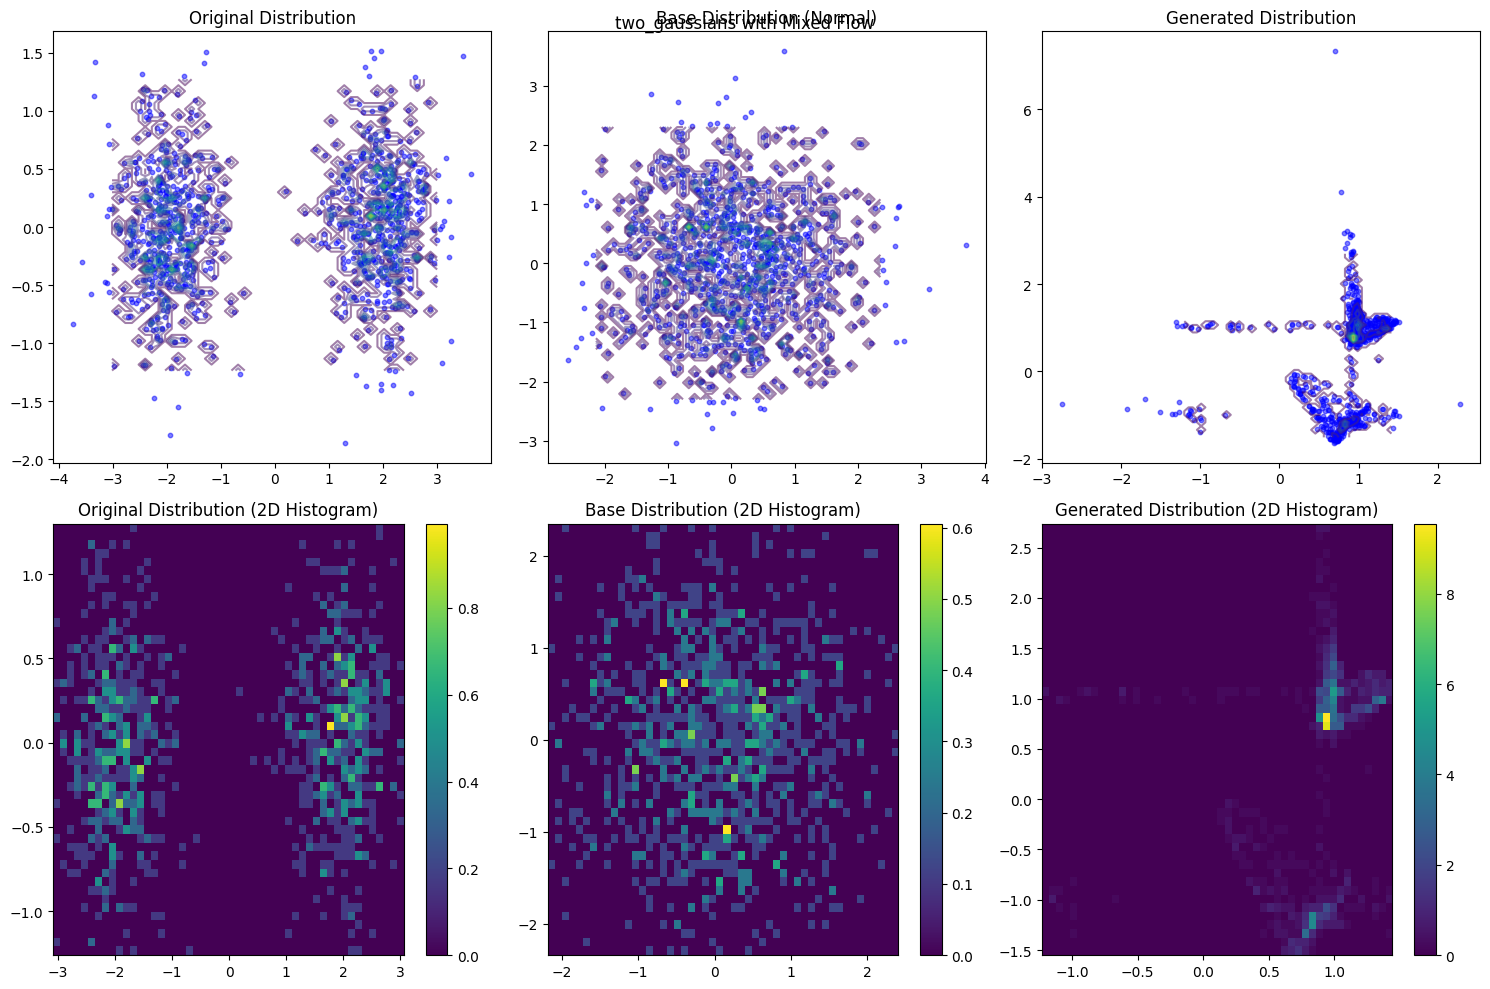

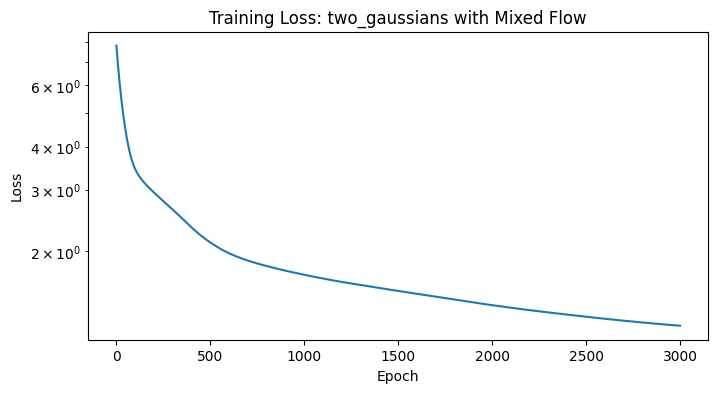


Training on circles dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 2.6860
Epoch 200/3000, Loss: 2.6705
Epoch 300/3000, Loss: 2.6560
Epoch 400/3000, Loss: 2.6423
Epoch 500/3000, Loss: 2.6294
Epoch 600/3000, Loss: 2.6173
Epoch 700/3000, Loss: 2.6059
Epoch 800/3000, Loss: 2.5951
Epoch 900/3000, Loss: 2.5849
Epoch 1000/3000, Loss: 2.5753
Epoch 1100/3000, Loss: 2.5662
Epoch 1200/3000, Loss: 2.5575
Epoch 1300/3000, Loss: 2.5492
Epoch 1400/3000, Loss: 2.5414
Epoch 1500/3000, Loss: 2.5339
Epoch 1600/3000, Loss: 2.5268
Epoch 1700/3000, Loss: 2.5199
Epoch 1800/3000, Loss: 2.5134
Epoch 1900/3000, Loss: 2.5071
Epoch 2000/3000, Loss: 2.5011
Epoch 2100/3000, Loss: 2.4953
Epoch 2200/3000, Loss: 2.4898
Epoch 2300/3000, Loss: 2.4845
Epoch 2400/3000, Loss: 2.4794
Epoch 2500/3000, Loss: 2.4745
Epoch 2600/3000, Loss: 2.4698
Epoch 2700/3000, Loss: 2.4653
Epoch 2800/3000, Loss: 2.4610
Epoch 2900/3000, Loss: 2.4569
Epoch 3000/3000, Loss: 2.4529


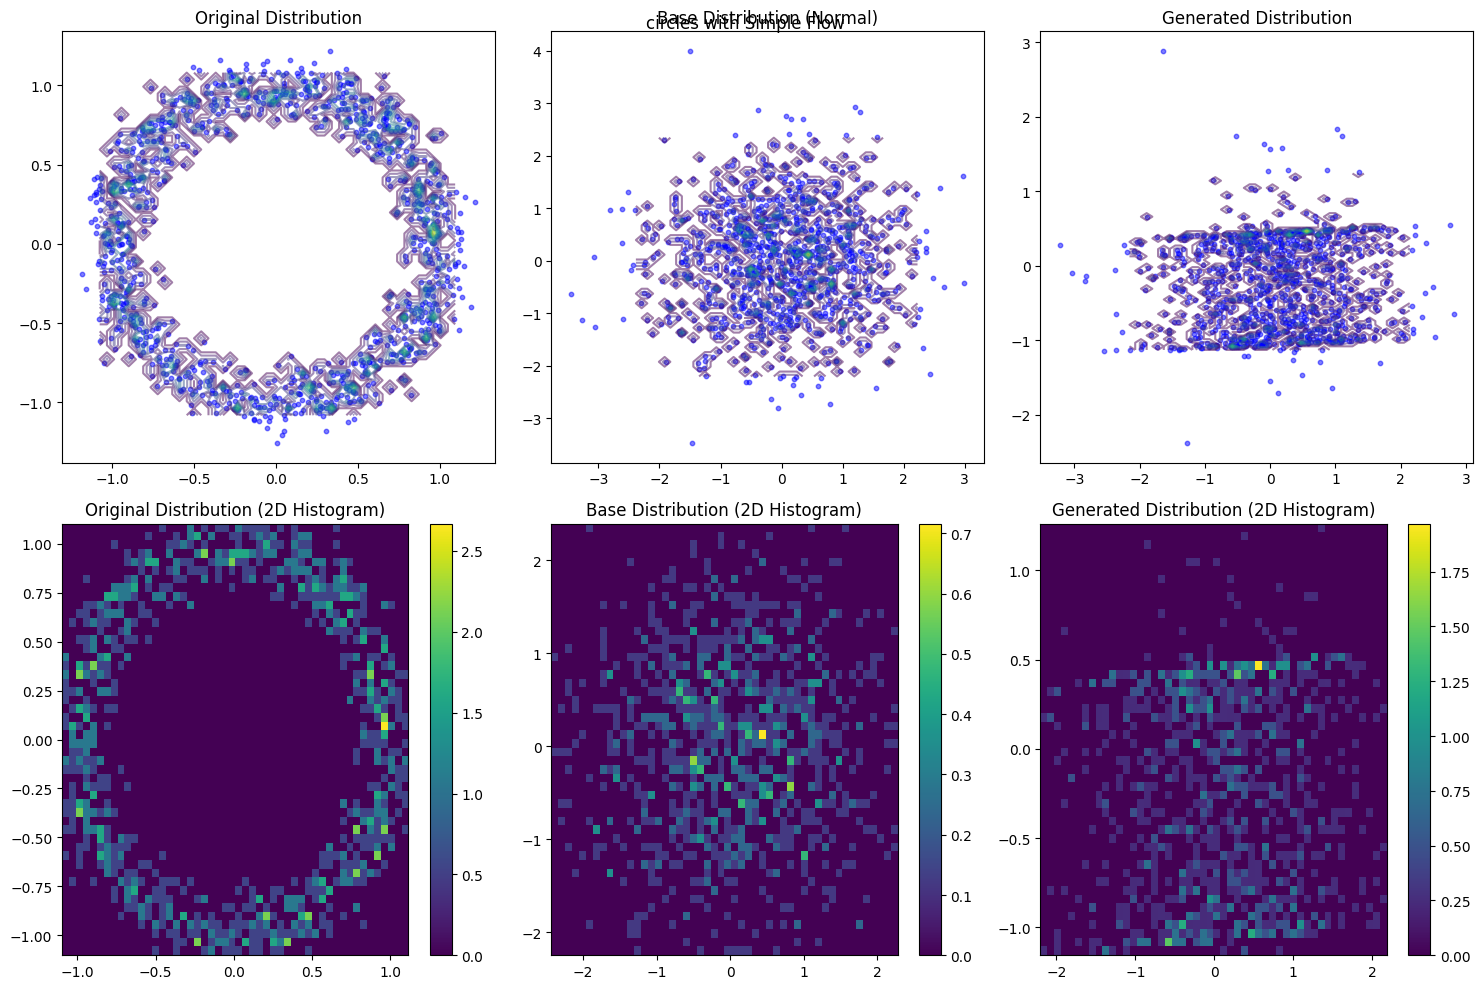

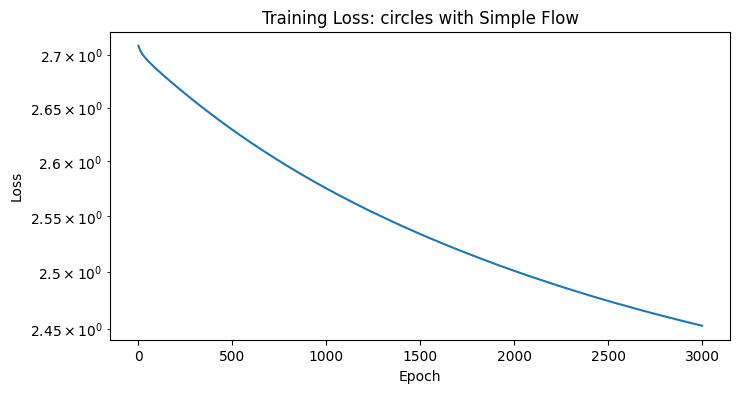


Training RealNVP architecture...
Epoch 100/3000, Loss: 2.1731
Epoch 200/3000, Loss: 2.1151
Epoch 300/3000, Loss: 2.0942
Epoch 400/3000, Loss: 2.0843
Epoch 500/3000, Loss: 2.0785
Epoch 600/3000, Loss: 2.0756
Epoch 700/3000, Loss: 2.0737
Epoch 800/3000, Loss: 2.0725
Epoch 900/3000, Loss: 2.0717
Epoch 1000/3000, Loss: 2.0711
Epoch 1100/3000, Loss: 2.0706
Epoch 1200/3000, Loss: 2.0702
Epoch 1300/3000, Loss: 2.0699
Epoch 1400/3000, Loss: 2.0696
Epoch 1500/3000, Loss: 2.0693
Epoch 1600/3000, Loss: 2.0691
Epoch 1700/3000, Loss: 2.0688
Epoch 1800/3000, Loss: 2.0686
Epoch 1900/3000, Loss: 2.0684
Epoch 2000/3000, Loss: 2.0681
Epoch 2100/3000, Loss: 2.0679
Epoch 2200/3000, Loss: 2.0677
Epoch 2300/3000, Loss: 2.0675
Epoch 2400/3000, Loss: 2.0672
Epoch 2500/3000, Loss: 2.0670
Epoch 2600/3000, Loss: 2.0668
Epoch 2700/3000, Loss: 2.0666
Epoch 2800/3000, Loss: 2.0664
Epoch 2900/3000, Loss: 2.0662
Epoch 3000/3000, Loss: 2.0660


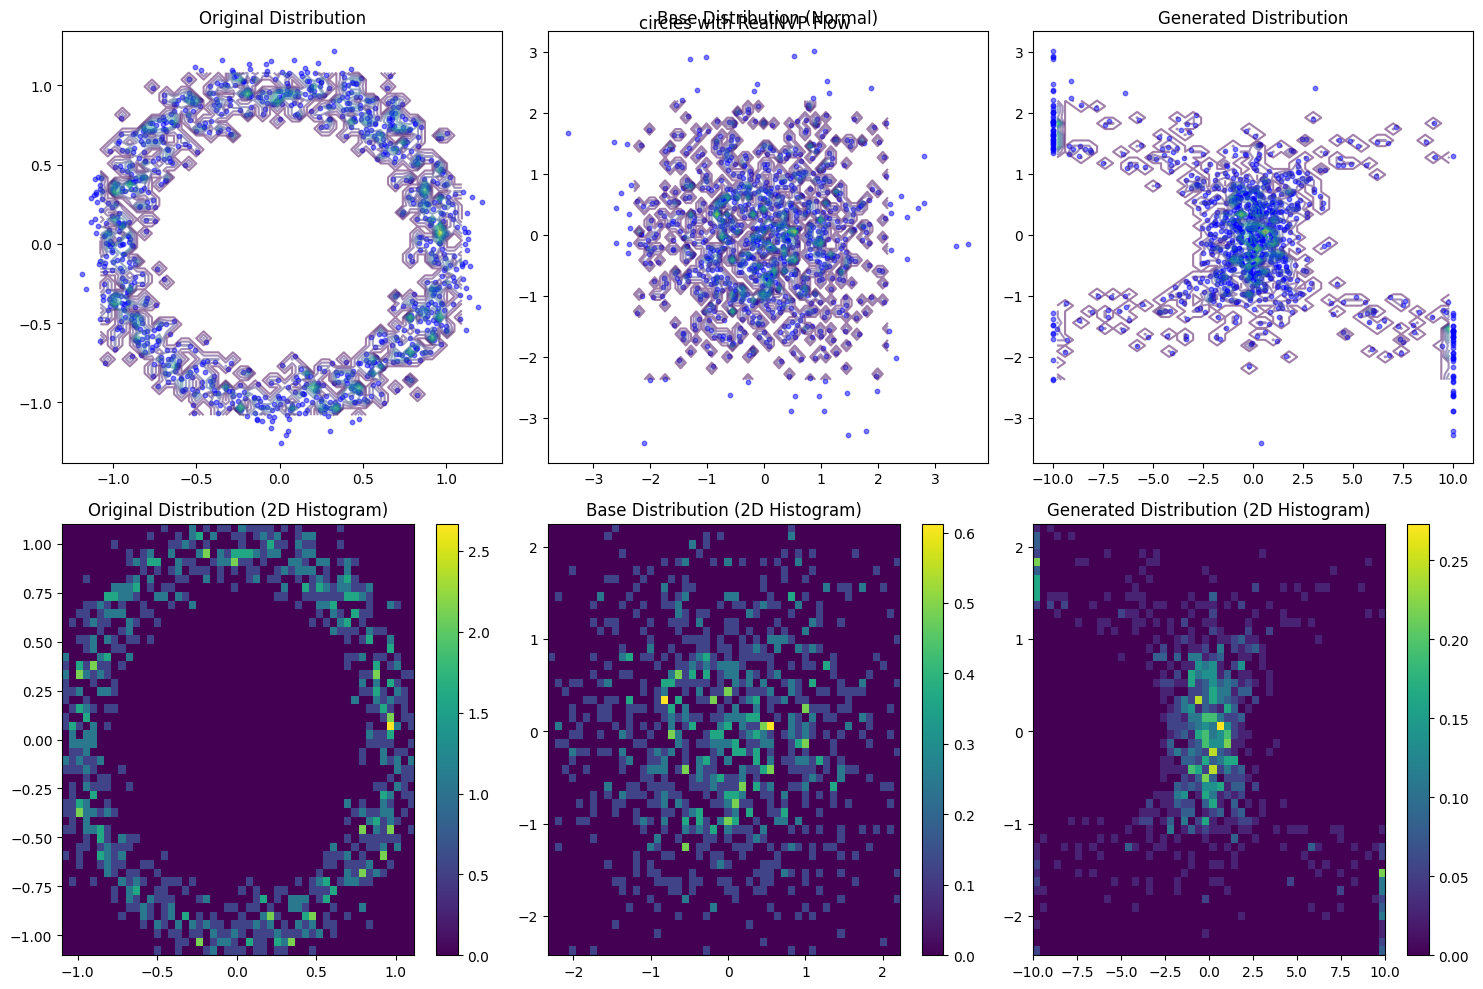

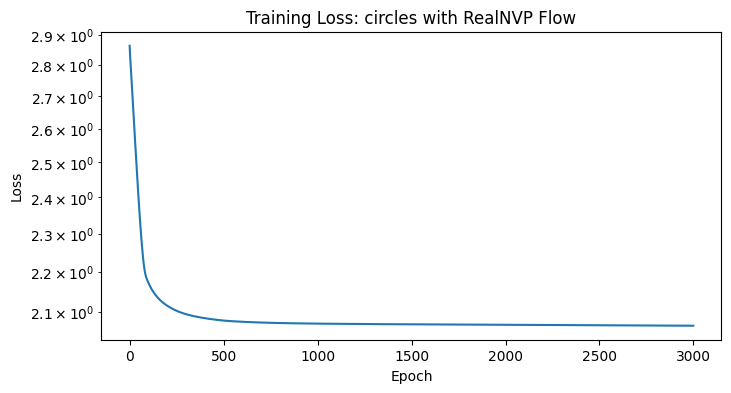


Training MAF architecture...
Epoch 100/3000, Loss: 1.9453
Epoch 200/3000, Loss: 1.9130
Epoch 300/3000, Loss: 1.8867
Epoch 400/3000, Loss: 1.8762
Epoch 500/3000, Loss: 1.8695
Epoch 600/3000, Loss: 1.8649
Epoch 700/3000, Loss: 1.8601
Epoch 800/3000, Loss: 1.8574
Epoch 900/3000, Loss: 1.8527
Epoch 1000/3000, Loss: 1.8477
Epoch 1100/3000, Loss: 1.8432
Epoch 1200/3000, Loss: 1.8388
Epoch 1300/3000, Loss: 1.8369
Epoch 1400/3000, Loss: 1.8328
Epoch 1500/3000, Loss: 1.8275
Epoch 1600/3000, Loss: 1.8228
Epoch 1700/3000, Loss: 1.8180
Epoch 1800/3000, Loss: 1.8131
Epoch 1900/3000, Loss: 1.8090
Epoch 2000/3000, Loss: 1.8056
Epoch 2100/3000, Loss: 1.8046
Epoch 2200/3000, Loss: 1.8009
Epoch 2300/3000, Loss: 1.7992
Epoch 2400/3000, Loss: 1.8003
Epoch 2500/3000, Loss: 1.7967
Epoch 2600/3000, Loss: 1.7955
Epoch 2700/3000, Loss: 1.7944
Epoch 2800/3000, Loss: 1.7935
Epoch 2900/3000, Loss: 1.7926
Epoch 3000/3000, Loss: 1.7917


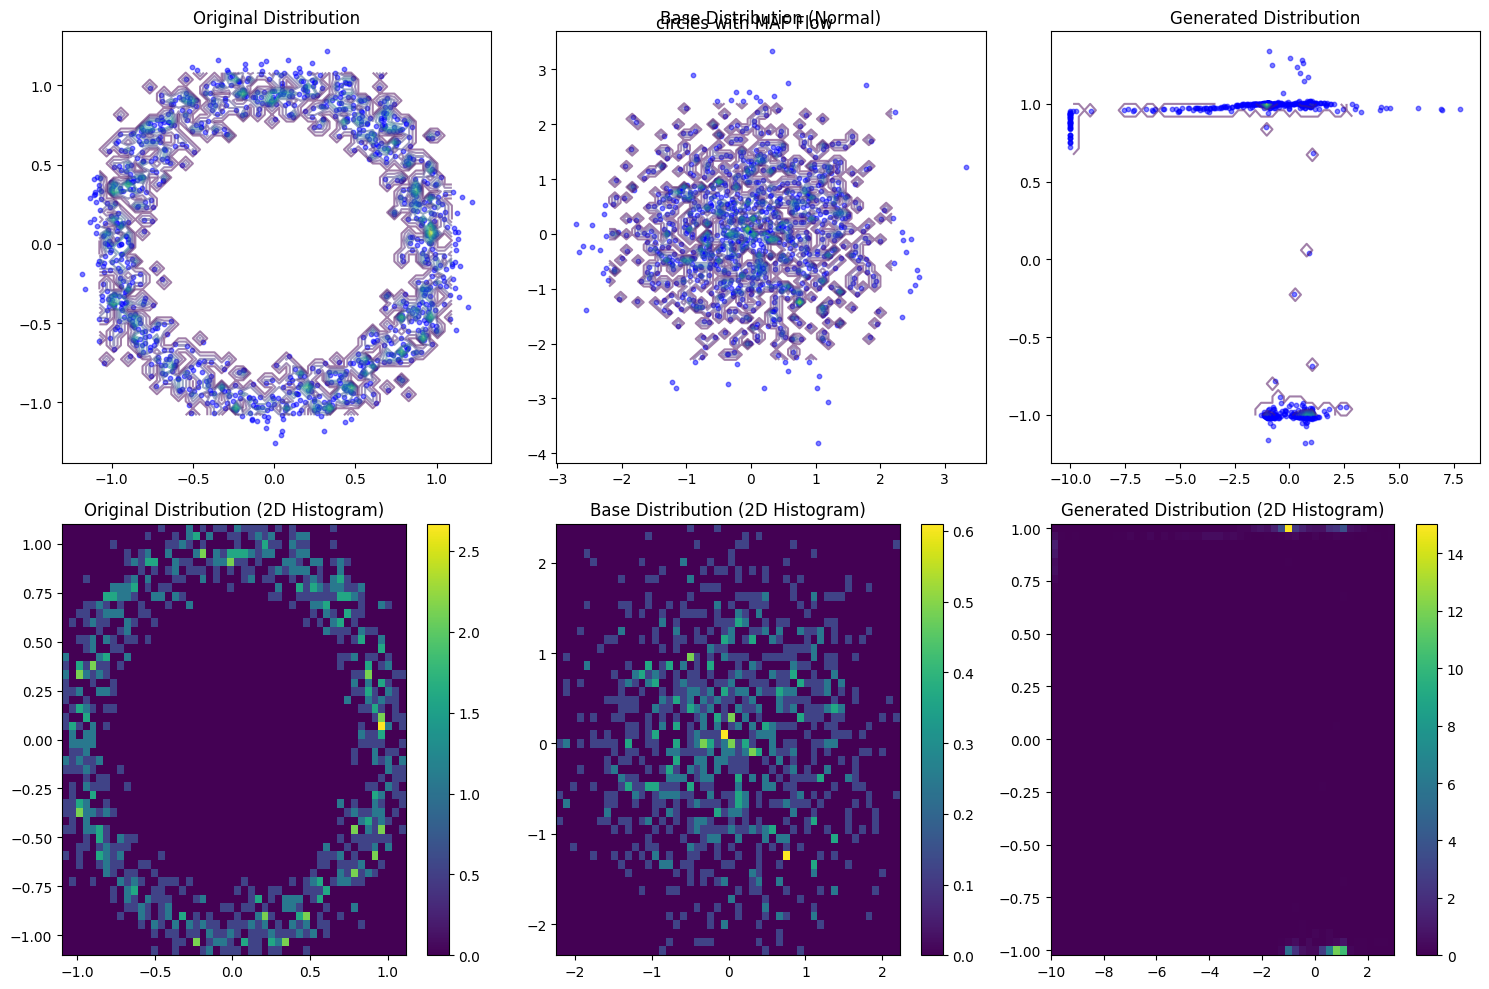

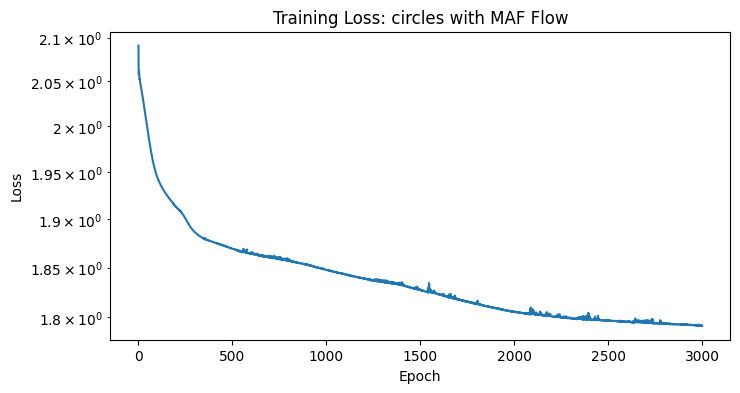


Training Mixed architecture...
Epoch 100/3000, Loss: 1.1245
Epoch 200/3000, Loss: 0.9325
Epoch 300/3000, Loss: 0.8537
Epoch 400/3000, Loss: 0.8087
Epoch 500/3000, Loss: 0.7765
Epoch 600/3000, Loss: 0.7543
Epoch 700/3000, Loss: 0.7337
Epoch 800/3000, Loss: 0.7128
Epoch 900/3000, Loss: 0.6952
Epoch 1000/3000, Loss: 0.6781
Epoch 1100/3000, Loss: 0.6608
Epoch 1200/3000, Loss: 0.6442
Epoch 1300/3000, Loss: 0.6296
Epoch 1400/3000, Loss: 0.6159
Epoch 1500/3000, Loss: 0.6024
Epoch 1600/3000, Loss: 0.5897
Epoch 1700/3000, Loss: 0.5775
Epoch 1800/3000, Loss: 0.5672
Epoch 1900/3000, Loss: 0.5577
Epoch 2000/3000, Loss: 0.5520
Epoch 2100/3000, Loss: 0.5452
Epoch 2200/3000, Loss: 0.5408
Epoch 2300/3000, Loss: 0.5362
Epoch 2400/3000, Loss: 0.5317
Epoch 2500/3000, Loss: 0.5273
Epoch 2600/3000, Loss: 0.5230
Epoch 2700/3000, Loss: 0.5190
Epoch 2800/3000, Loss: 0.5166
Epoch 2900/3000, Loss: 0.5133
Epoch 3000/3000, Loss: 0.5097


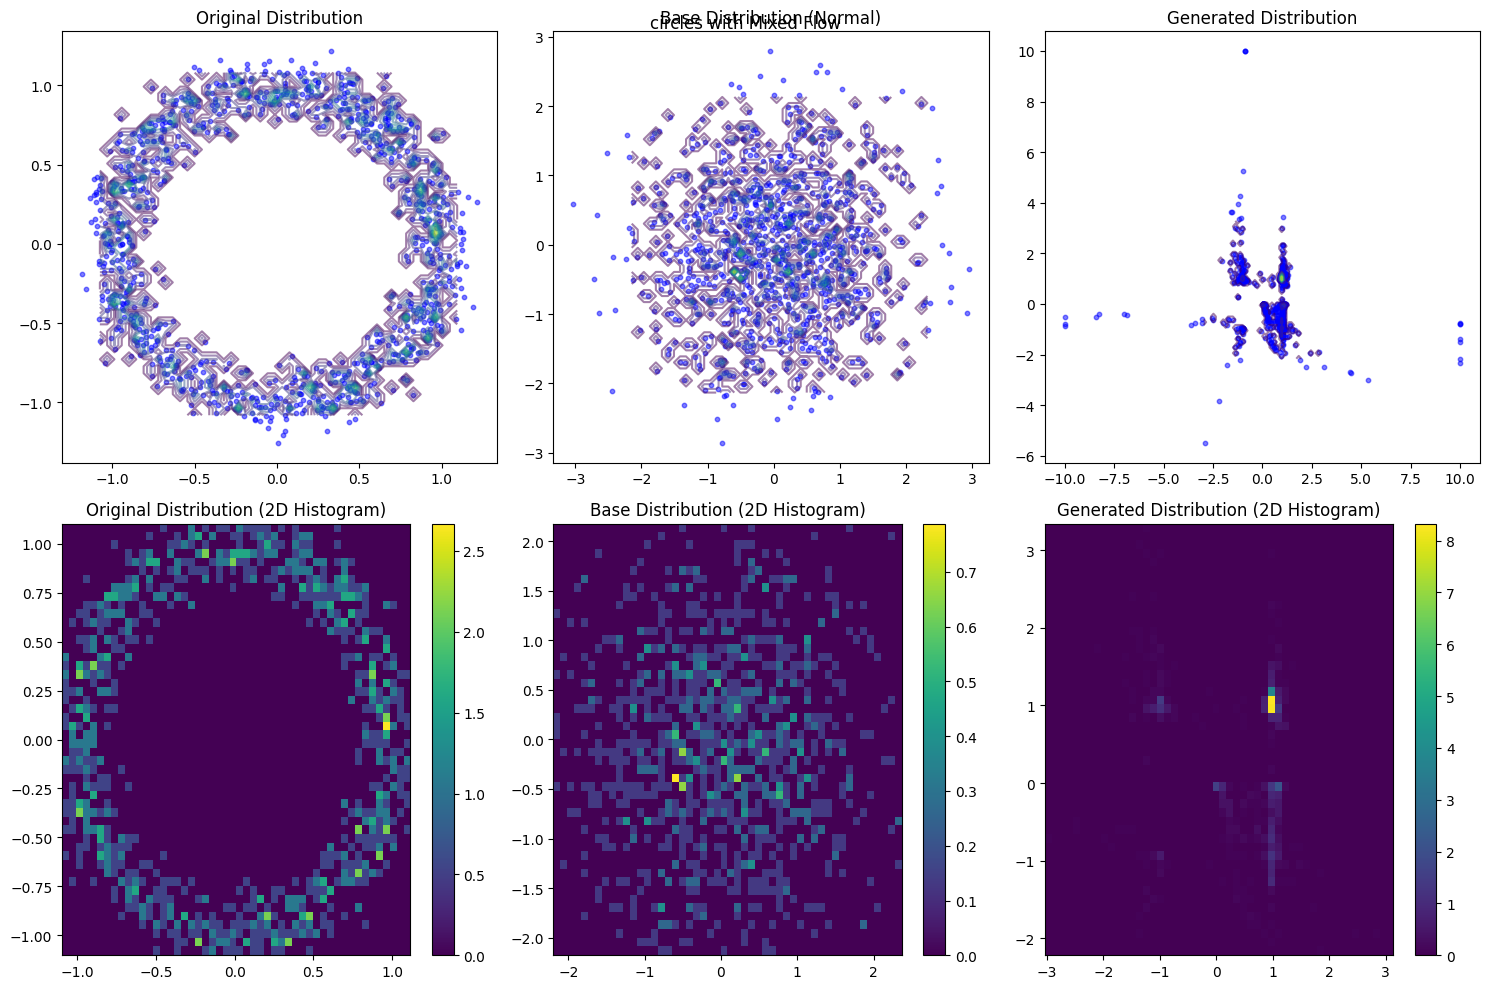

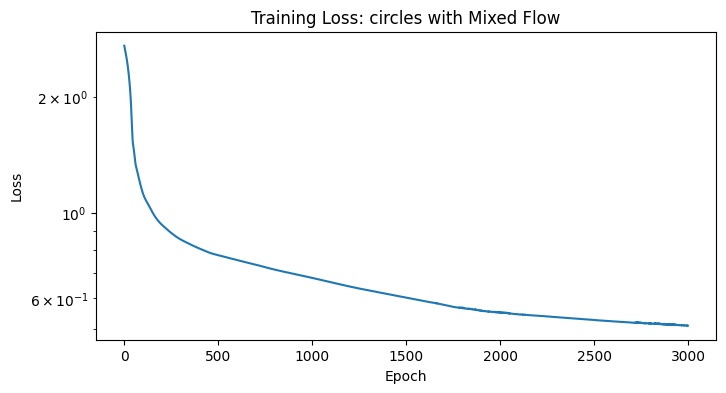


Training on moons dataset:

Training Simple architecture...
Epoch 100/3000, Loss: 2.4054
Epoch 200/3000, Loss: 2.3961
Epoch 300/3000, Loss: 2.3880
Epoch 400/3000, Loss: 2.3805
Epoch 500/3000, Loss: 2.3734
Epoch 600/3000, Loss: 2.3668
Epoch 700/3000, Loss: 2.3606
Epoch 800/3000, Loss: 2.3546
Epoch 900/3000, Loss: 2.3489
Epoch 1000/3000, Loss: 2.3436
Epoch 1100/3000, Loss: 2.3384
Epoch 1200/3000, Loss: 2.3335
Epoch 1300/3000, Loss: 2.3287
Epoch 1400/3000, Loss: 2.3241
Epoch 1500/3000, Loss: 2.3197
Epoch 1600/3000, Loss: 2.3154
Epoch 1700/3000, Loss: 2.3112
Epoch 1800/3000, Loss: 2.3071
Epoch 1900/3000, Loss: 2.3030
Epoch 2000/3000, Loss: 2.2990
Epoch 2100/3000, Loss: 2.2951
Epoch 2200/3000, Loss: 2.2912
Epoch 2300/3000, Loss: 2.2873
Epoch 2400/3000, Loss: 2.2835
Epoch 2500/3000, Loss: 2.2797
Epoch 2600/3000, Loss: 2.2759
Epoch 2700/3000, Loss: 2.2721
Epoch 2800/3000, Loss: 2.2684
Epoch 2900/3000, Loss: 2.2647
Epoch 3000/3000, Loss: 2.2611


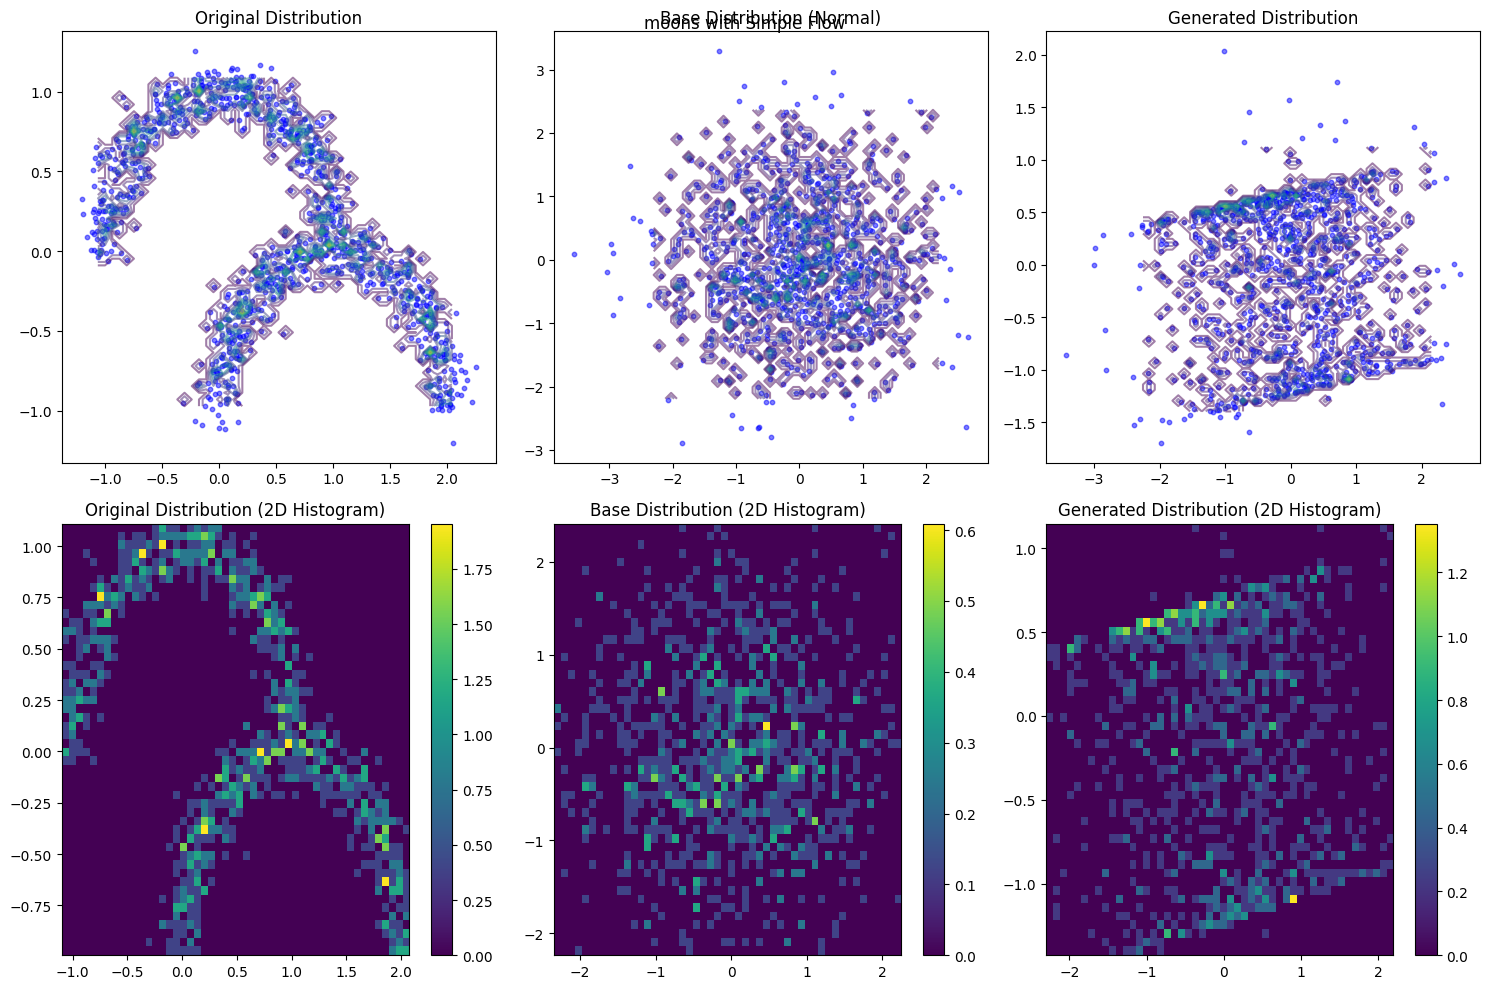

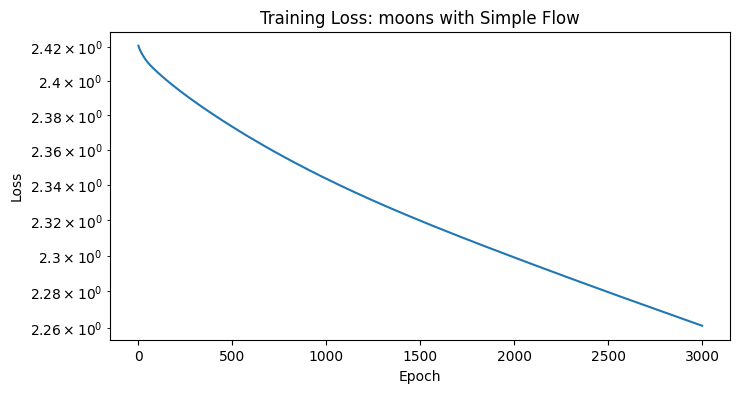


Training RealNVP architecture...
Epoch 100/3000, Loss: 2.1744
Epoch 200/3000, Loss: 2.1439
Epoch 300/3000, Loss: 2.1310
Epoch 400/3000, Loss: 2.1237
Epoch 500/3000, Loss: 2.1192
Epoch 600/3000, Loss: 2.1163
Epoch 700/3000, Loss: 2.1144
Epoch 800/3000, Loss: 2.1130
Epoch 900/3000, Loss: 2.1118
Epoch 1000/3000, Loss: 2.1108
Epoch 1100/3000, Loss: 2.1098
Epoch 1200/3000, Loss: 2.1089
Epoch 1300/3000, Loss: 2.1082
Epoch 1400/3000, Loss: 2.1075
Epoch 1500/3000, Loss: 2.1068
Epoch 1600/3000, Loss: 2.1061
Epoch 1700/3000, Loss: 2.1055
Epoch 1800/3000, Loss: 2.1050
Epoch 1900/3000, Loss: 2.1044
Epoch 2000/3000, Loss: 2.1039
Epoch 2100/3000, Loss: 2.1034
Epoch 2200/3000, Loss: 2.1029
Epoch 2300/3000, Loss: 2.1025
Epoch 2400/3000, Loss: 2.1021
Epoch 2500/3000, Loss: 2.1016
Epoch 2600/3000, Loss: 2.1013
Epoch 2700/3000, Loss: 2.1008
Epoch 2800/3000, Loss: 2.1004
Epoch 2900/3000, Loss: 2.1000
Epoch 3000/3000, Loss: 2.0996


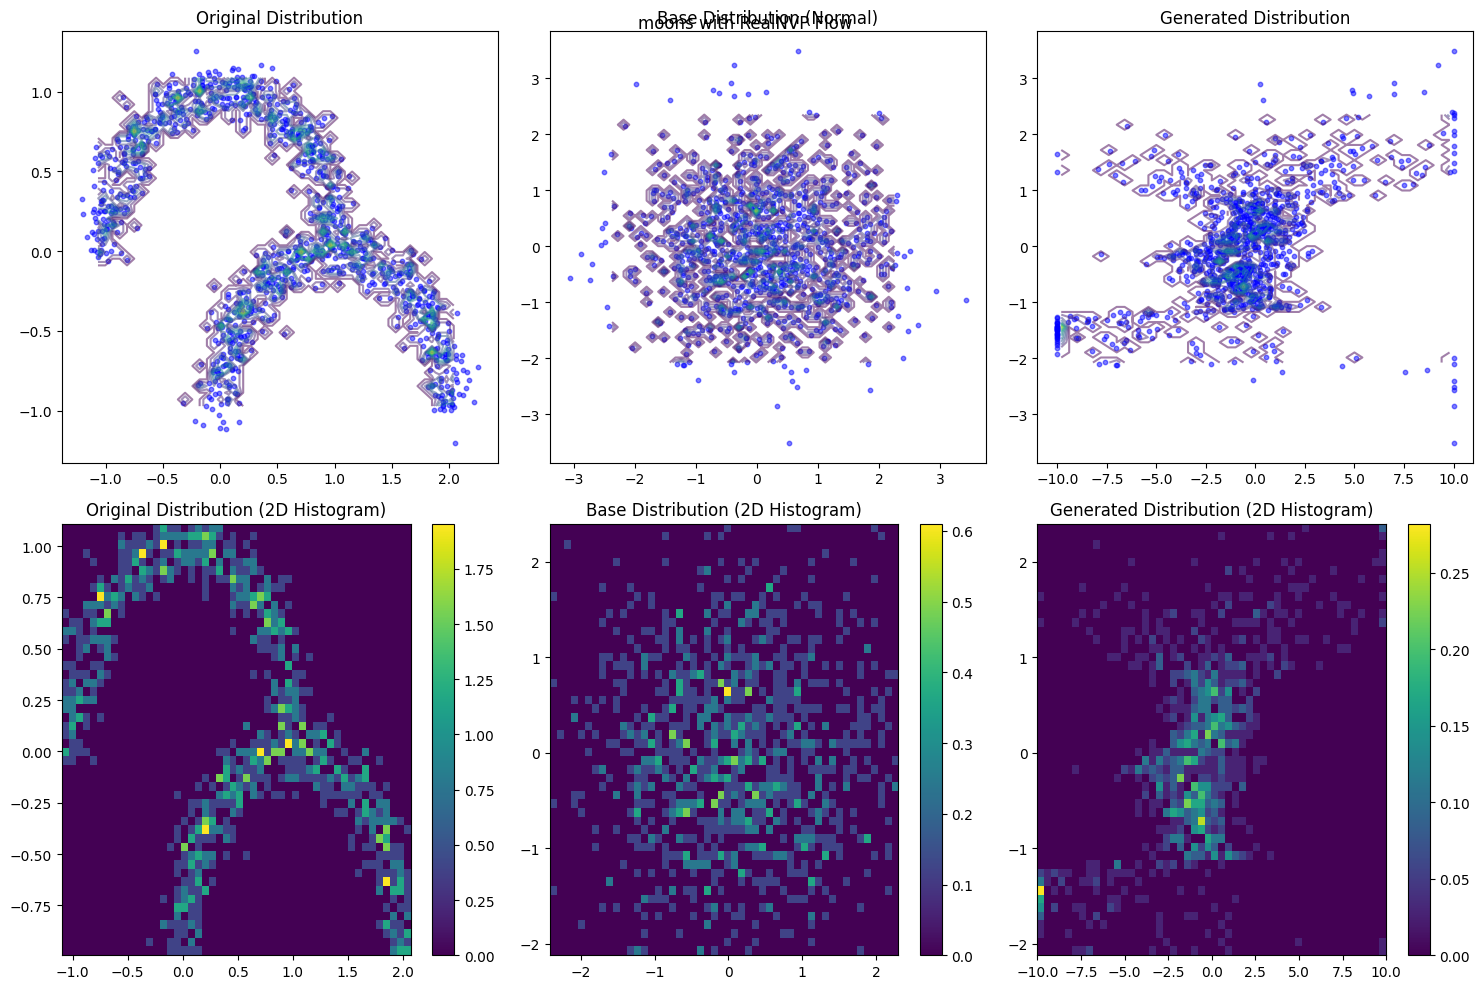

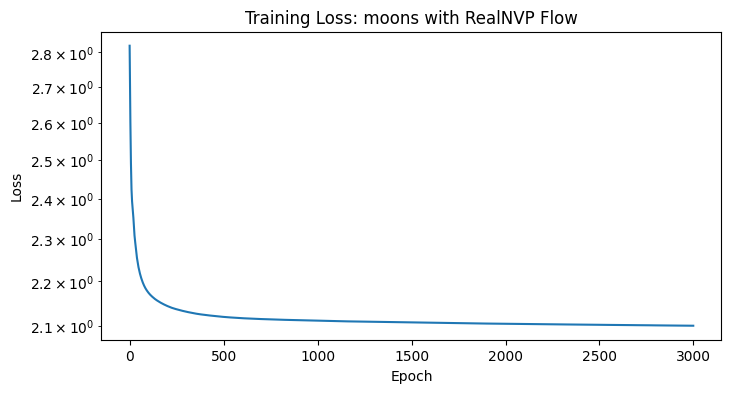


Training MAF architecture...
Epoch 100/3000, Loss: 2.1407
Epoch 200/3000, Loss: 2.1319
Epoch 300/3000, Loss: 2.1272
Epoch 400/3000, Loss: 2.1241
Epoch 500/3000, Loss: 2.1214
Epoch 600/3000, Loss: 2.1194
Epoch 700/3000, Loss: 2.1171
Epoch 800/3000, Loss: 2.1154
Epoch 900/3000, Loss: 2.1134
Epoch 1000/3000, Loss: 2.1118
Epoch 1100/3000, Loss: 2.1104
Epoch 1200/3000, Loss: 2.1090
Epoch 1300/3000, Loss: 2.1074
Epoch 1400/3000, Loss: 2.1058
Epoch 1500/3000, Loss: 2.1044
Epoch 1600/3000, Loss: 2.1037
Epoch 1700/3000, Loss: 2.1024
Epoch 1800/3000, Loss: 2.1014
Epoch 1900/3000, Loss: 2.1000
Epoch 2000/3000, Loss: 2.0993
Epoch 2100/3000, Loss: 2.0986
Epoch 2200/3000, Loss: 2.0971
Epoch 2300/3000, Loss: 2.0953
Epoch 2400/3000, Loss: 2.0942
Epoch 2500/3000, Loss: 2.0940
Epoch 2600/3000, Loss: 2.0926
Epoch 2700/3000, Loss: 2.0919
Epoch 2800/3000, Loss: 2.0913
Epoch 2900/3000, Loss: 2.0909
Epoch 3000/3000, Loss: 2.0905


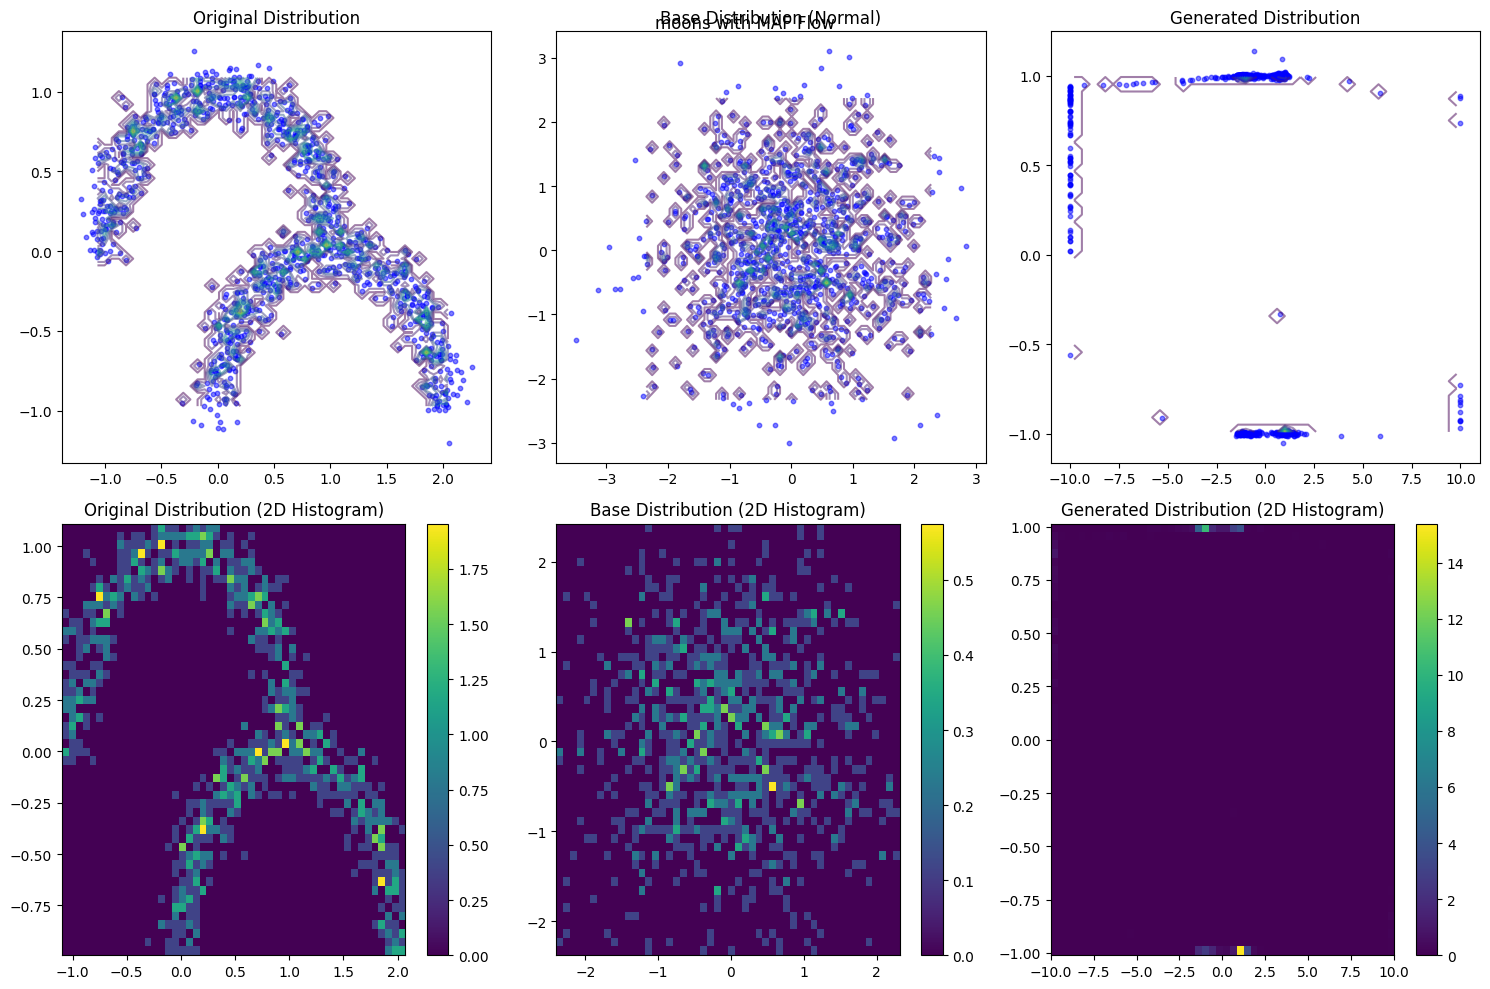

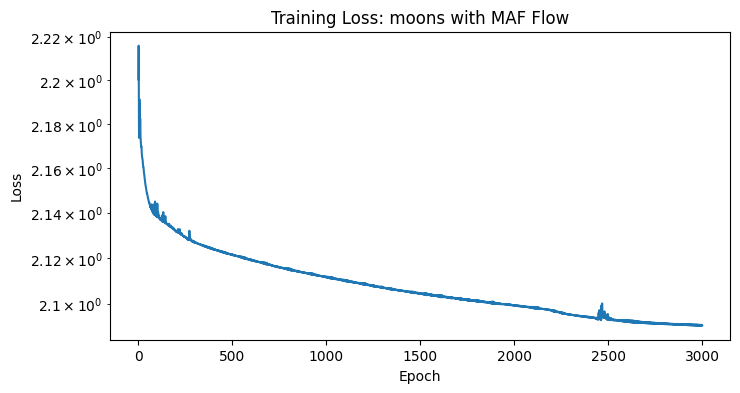


Training Mixed architecture...
Epoch 100/3000, Loss: 1.4126
Epoch 200/3000, Loss: 1.2627
Epoch 300/3000, Loss: 1.2299
Epoch 400/3000, Loss: 1.2103
Epoch 500/3000, Loss: 1.1953
Epoch 600/3000, Loss: 1.1821
Epoch 700/3000, Loss: 1.1647
Epoch 800/3000, Loss: 1.1525
Epoch 900/3000, Loss: 1.1434
Epoch 1000/3000, Loss: 1.1334
Epoch 1100/3000, Loss: 1.1243
Epoch 1200/3000, Loss: 1.1146
Epoch 1300/3000, Loss: 1.1017
Epoch 1400/3000, Loss: 1.0957
Epoch 1500/3000, Loss: 1.0877
Epoch 1600/3000, Loss: 1.0788
Epoch 1700/3000, Loss: 1.0728
Epoch 1800/3000, Loss: 1.0660
Epoch 1900/3000, Loss: 1.0605
Epoch 2000/3000, Loss: 1.0531
Epoch 2100/3000, Loss: 1.0438
Epoch 2200/3000, Loss: 1.0358
Epoch 2300/3000, Loss: 1.0284
Epoch 2400/3000, Loss: 1.0215
Epoch 2500/3000, Loss: 1.0051
Epoch 2600/3000, Loss: 0.9953
Epoch 2700/3000, Loss: 0.9833
Epoch 2800/3000, Loss: 0.9269
Epoch 2900/3000, Loss: 0.7543
Epoch 3000/3000, Loss: 0.7220


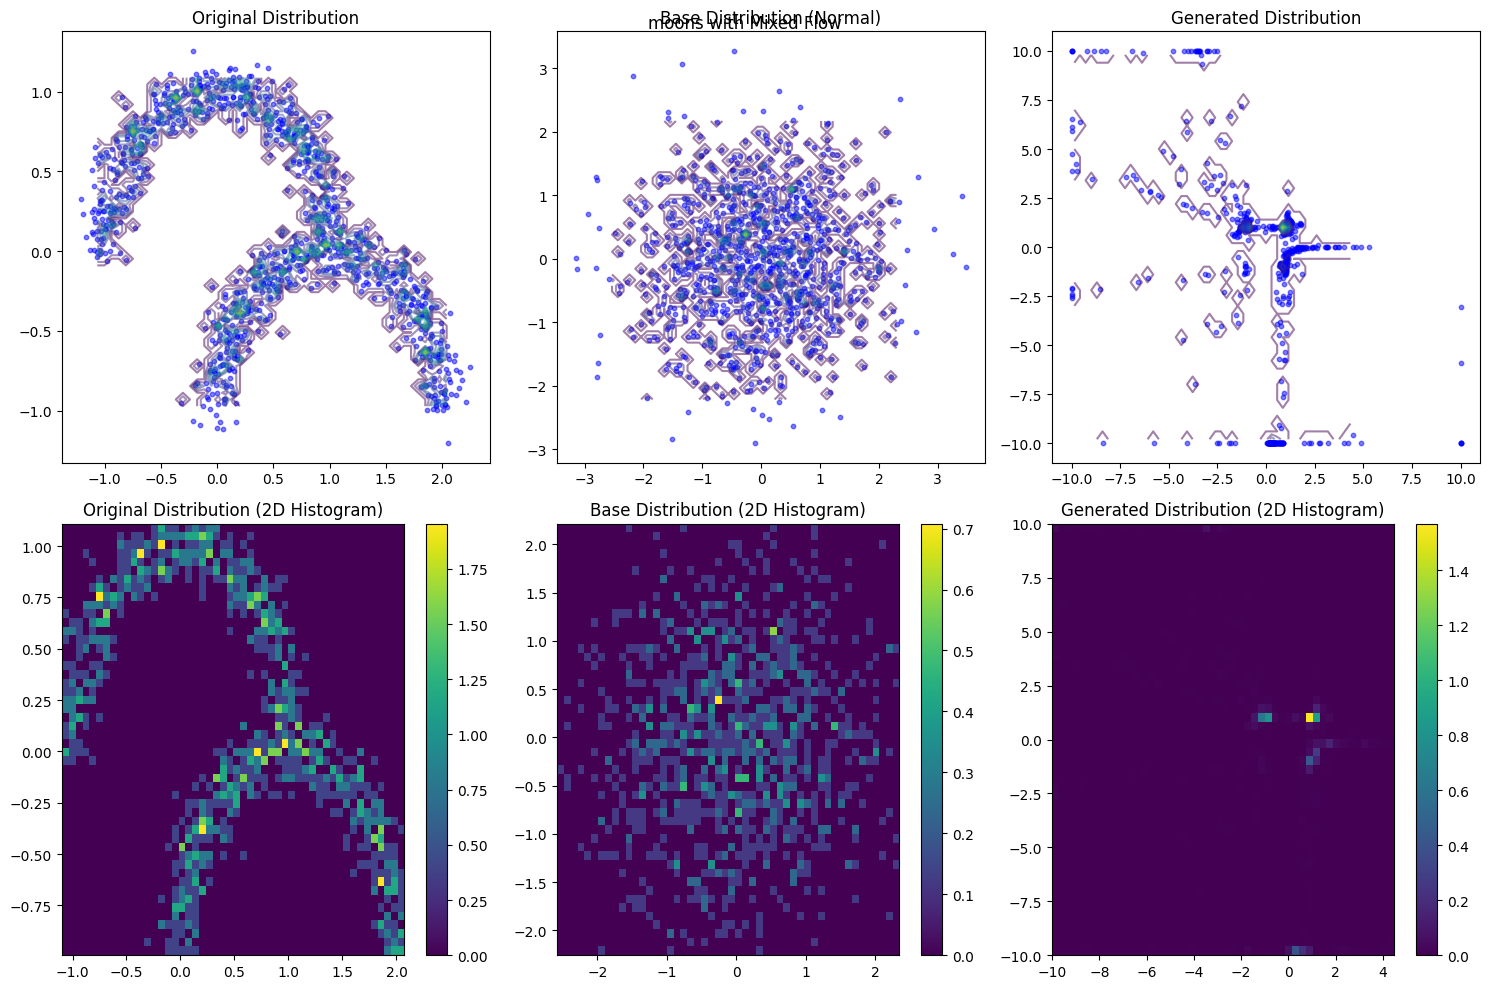

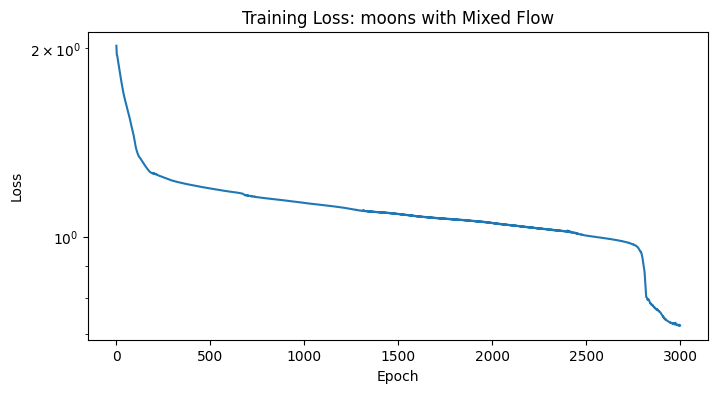

In [11]:
def main():
    # Generate toy datasets
    datasets = {
        'two_gaussians': create_toy_dataset(1000, 'two_gaussians'),
        'circles': create_toy_dataset(1000, 'circles'),
        'moons': create_toy_dataset(1000, 'moons')
    }
    
    # Create different flow models
    dim = 2
    flow_architectures = {
        'Simple': [
            PlanarFlow(dim),
            RadialFlow(dim),
            PlanarFlow(dim)
        ],
        'RealNVP': [
            RealNVPCoupling(dim),
            RealNVPCoupling(dim, mask_type='alternate'),
            RealNVPCoupling(dim, mask_type='half')
        ],
        'MAF': [
            MAF(dim),
            MAF(dim),
            MAF(dim)
        ],
        'Mixed': [
            PlanarFlow(dim),
            RealNVPCoupling(dim),
            MAF(dim)
        ]
    }
    
    # Train and visualize each combination
    for dataset_name, data in datasets.items():
        print(f"\nTraining on {dataset_name} dataset:")
        for arch_name, flows in flow_architectures.items():
            print(f"\nTraining {arch_name} architecture...")
            
            # Initialize flow model
            flow_model = NormalizingFlow(flows)
            
            # Train with lower learning rate for stability
            trained_flow, losses = train_flow(flow_model, data, n_epochs=3000, lr=1e-4)
            
            # Visualize
            fig = visualize_flow(trained_flow, data)
            plt.suptitle(f'{dataset_name} with {arch_name} Flow')
            plt.show()
            
            # Plot loss curve
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.title(f'Training Loss: {dataset_name} with {arch_name} Flow')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            plt.show()

if __name__ == "__main__":
    main()